In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/london-bike-sharing-dataset/london_merged.csv


In [4]:
df = pd.read_csv('/kaggle/input/london-bike-sharing-dataset/london_merged.csv', parse_dates=['timestamp'])
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [5]:
df['timestamp']

0       2015-01-04 00:00:00
1       2015-01-04 01:00:00
2       2015-01-04 02:00:00
3       2015-01-04 03:00:00
4       2015-01-04 04:00:00
                ...        
17409   2017-01-03 19:00:00
17410   2017-01-03 20:00:00
17411   2017-01-03 21:00:00
17412   2017-01-03 22:00:00
17413   2017-01-03 23:00:00
Name: timestamp, Length: 17414, dtype: datetime64[ns]

In [6]:
df.shape

(17414, 10)

In [7]:
#17000개 학습용, 414개 테스트용

train = df.iloc[:17000,1:2]
test = df.iloc[17000:17414, 1:2]

In [8]:
print(train.shape)
print(test.shape)

(17000, 1)
(414, 1)


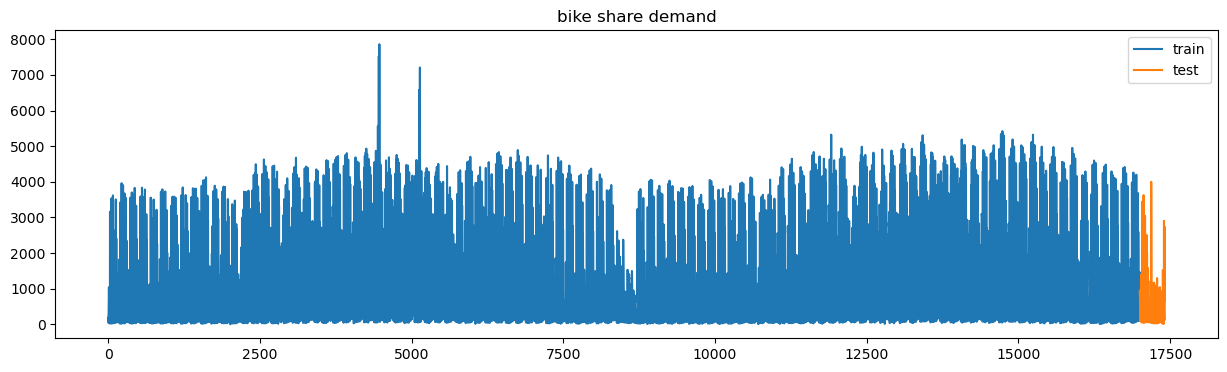

In [9]:
df['cnt'][:17000].plot(figsize=(15,4), legend=True)
df['cnt'][17000:].plot(figsize=(15,4), legend=True)
plt.legend(['train','test'])
plt.title('bike share demand')
plt.show()

In [10]:
#시계열 분석을 위한 데이터 전처리 작업
#별도의 변수는 필요없다. 몇시간 전 데이터를 통해서 학습. 차수를 추정하는 방법.

In [11]:
#pacf 이용하여 차수 추정
from statsmodels.tsa.stattools import pacf
pacf = pacf(df['cnt'], nlags=20, method='ols')
print(pacf)

[ 1.          0.78148357 -0.41172684  0.18486682 -0.07510114 -0.09947694
 -0.08494917 -0.00403993  0.0920456   0.07065422 -0.32935188 -0.06873344
  0.05112775  0.04852911  0.06695059 -0.19621297 -0.07610221  0.14365297
 -0.11638129  0.18990804  0.16480713]


<bound method Figure.show of <Figure size 640x480 with 1 Axes>>

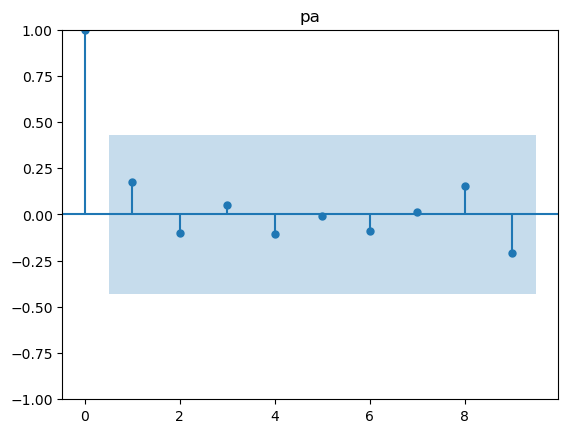

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(pacf, lags=9, method='ols', title='pa').show

In [13]:
#전처리 작업 - 데이터의 스케일작업 (MinMaxscale)

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
train_scaled = sc.fit_transform(train)

In [14]:
train_scaled

array([[0.02315522],
       [0.01755725],
       [0.01704835],
       ...,
       [0.17468193],
       [0.16348601],
       [0.14083969]])

In [15]:
train_scaled.shape

(17000, 1)

In [16]:
#시계열 딥러닝은 자기 자신의 과거를 독립변수로 활용한다. 1시간 단위로 시프트 시키는 작업을 해본다.

In [17]:
x_train = []
y_train = []

for i in range(1, 17000):
    x_train.append(train_scaled[i-1:i, 0])
    y_train.append(train_scaled[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [18]:
x_train.shape

(16999, 1)

In [19]:
#시계열 딥러닝은 3차원 배열을 필요로 한다. 3차원 배열로 전처리

In [20]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_train.shape

(16999, 1, 1)

In [21]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import SimpleRNN

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [22]:
rnn = Sequential()
rnn.add(SimpleRNN(activation='relu', units=6, input_shape=(1,1)))
rnn.add(Dense(activation='linear', units=1))

In [23]:
print(rnn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 6)                 48        
                                                                 
 dense (Dense)               (None, 1)                 7         
                                                                 
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
rnn.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [25]:
rnn.fit(x_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
16999/16999 [==============================] - 35s 2ms/step - loss: 0.0069 - mse: 0.0069
Epoch 2/2
16999/16999 [==============================] - 33s 2ms/step - loss: 0.0068 - mse: 0.0068


In [26]:
inputs = sc.transform(test)
inputs.shape

(414, 1)

In [27]:
x_test = []
for i in range(1, 415):
    x_test.append(inputs[i-1:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
x_test.shape

(414, 1, 1)

In [28]:
rnn = rnn.predict(x_test)
rnn = sc.inverse_transform(rnn)

13/13 [==============================] - 0s 2ms/step


In [29]:
test1 = pd.DataFrame(test)
rnn1= pd.DataFrame(rnn)

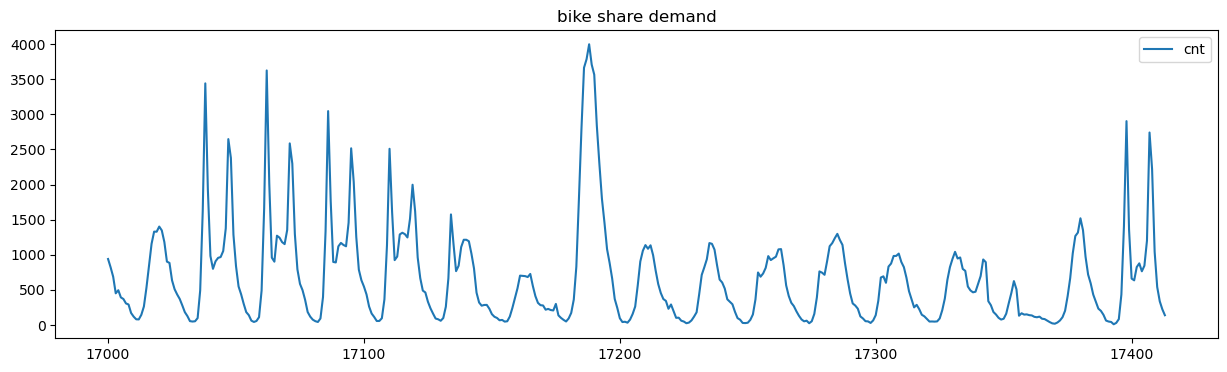

In [30]:
test1.plot(figsize=(15,4), legend=True)
plt.legend(['cnt'])
plt.title('bike share demand')
plt.show()

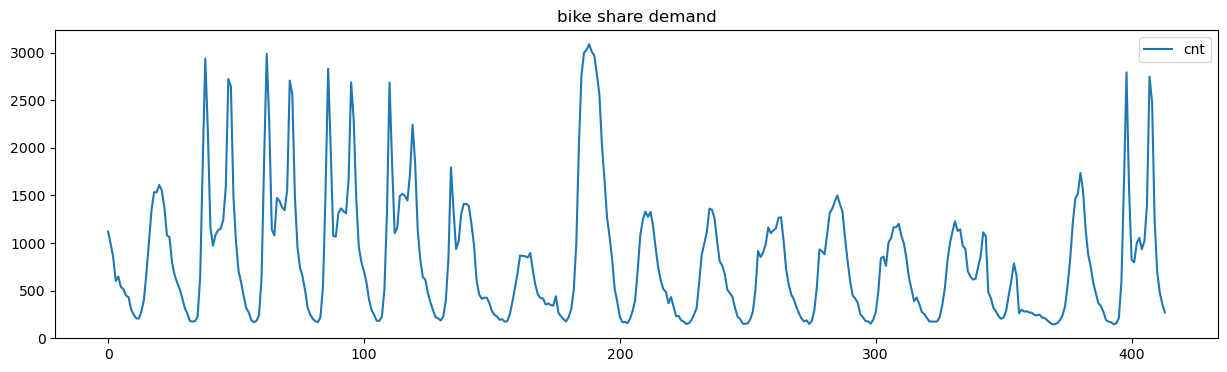

In [31]:
rnn1.plot(figsize=(15,4), legend=True)
plt.legend(['RNN'])
plt.title('bike share demand')
plt.show()

In [32]:
test = np.array(test)

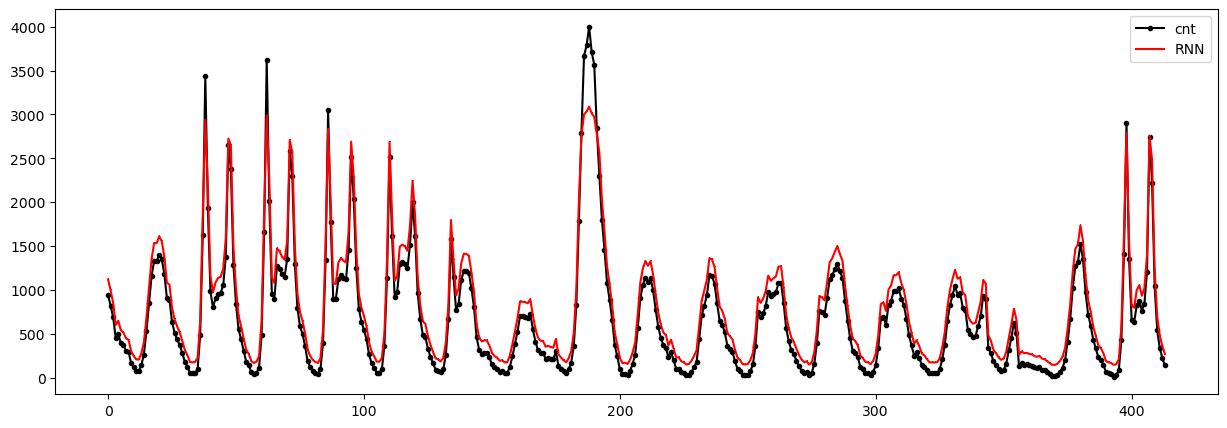

In [40]:
plt.figure(figsize=(15,5))
plt.plot(test, marker='.', label='cnt', color='black')
plt.plot(rnn, marker=',', label='RNN', color='red')
plt.legend()

In [36]:
from keras.layers import LSTM
lstm = Sequential()
lstm.add(LSTM(units=6, activation='relu', input_shape=(1,1)))
lstm.add(Dense(units=1, activation='linear'))

In [37]:
print(lstm.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6)                 192       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
lstm.compile(loss='mse', optimizer='adam', metrics=['mse'])
lstm.fit(x_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
16999/16999 [==============================] - 44s 3ms/step - loss: 0.0084 - mse: 0.0084
Epoch 2/2
16999/16999 [==============================] - 41s 2ms/step - loss: 0.0068 - mse: 0.0068


In [39]:
lstm = lstm.predict(x_test)
lstm = sc.inverse_transform(lstm)

13/13 [==============================] - 0s 2ms/step


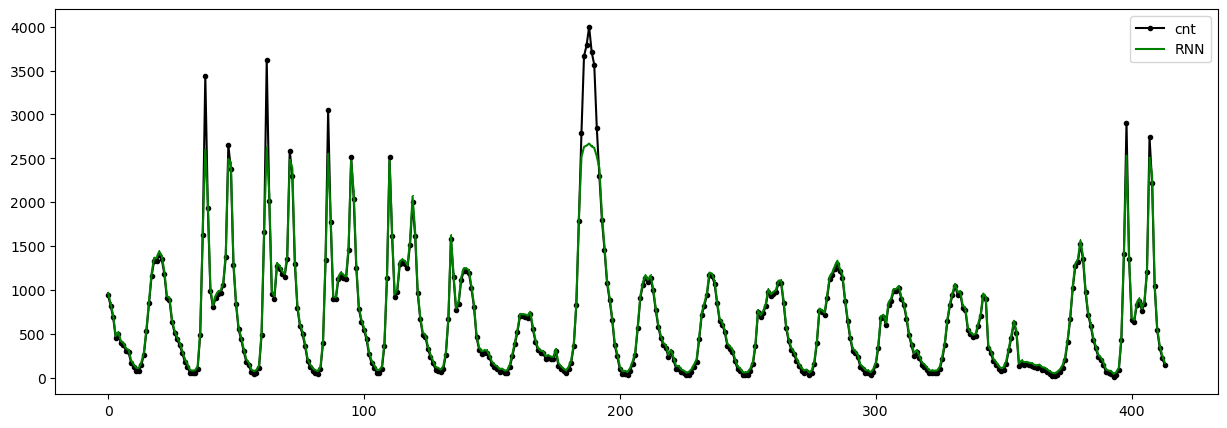

In [41]:
plt.figure(figsize=(15,5))
plt.plot(test, marker='.', label='cnt', color='black')
plt.plot(lstm, marker=',', label='RNN', color='green')
plt.legend()

In [43]:
from keras.layers import GRU

gru = Sequential()
gru.add(GRU(units=6, activation='relu', input_shape=(1,1)))
gru.add(Dense(units=1, activation='linear'))

In [44]:
print(gru.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 6)                 162       
                                                                 
 dense_2 (Dense)             (None, 1)                 7         
                                                                 
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________
None


In [45]:
gru.compile(loss='mse', optimizer='adam', metrics=['mse'])
gru.fit(x_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
16999/16999 [==============================] - 38s 2ms/step - loss: 0.0074 - mse: 0.0074
Epoch 2/2
16999/16999 [==============================] - 40s 2ms/step - loss: 0.0068 - mse: 0.0068


In [46]:
gru = gru.predict(x_test)
gru = sc.inverse_transform(gru)

13/13 [==============================] - 0s 3ms/step


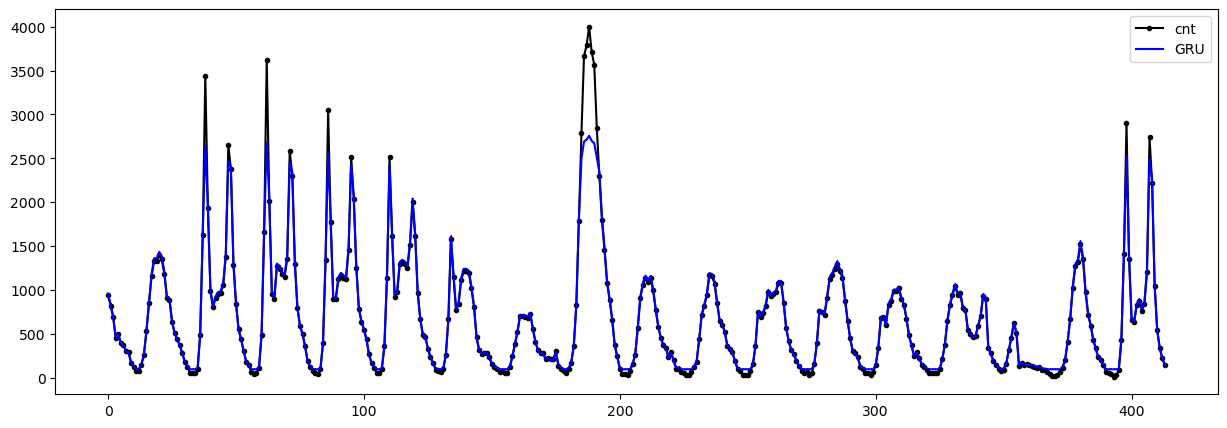

In [48]:
plt.figure(figsize=(15,5))
plt.plot(test, marker='.', label='cnt', color='black')
plt.plot(gru, marker=',', label='GRU', color='blue')
plt.legend()

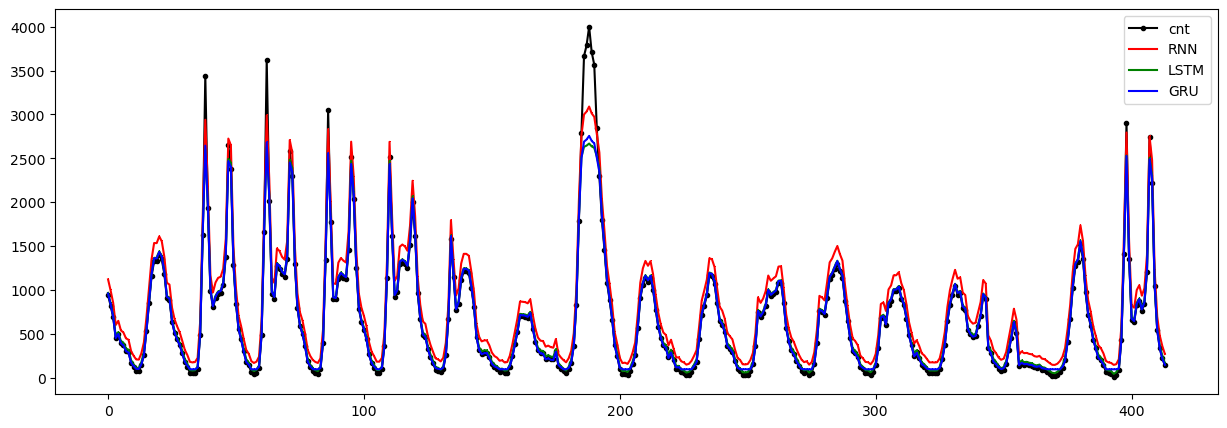

In [49]:
plt.figure(figsize=(15,5))
plt.plot(test, marker='.', label='cnt', color='black')
plt.plot(rnn, marker=',', label='RNN', color='red')
plt.plot(lstm, marker=',', label='LSTM', color='green')
plt.plot(gru, marker=',', label='GRU', color='blue')
plt.legend()

In [52]:
from sklearn.metrics import mean_squared_error

def RMSE(y_test, y_predict):
    return np.sqrt(mean_squared_error(y_test, y_predict))

In [53]:
print('RNN RMSE:', RMSE(test, rnn))

RNN RMSE: 182.24534960464288


In [54]:
print('LSTM RMSE:', RMSE(test, lstm))

LSTM RMSE: 146.8993589908664


In [55]:
print('GRU RMSE:', RMSE(test, gru))

GRU RMSE: 138.49414675718924
